# Clustering

### Introduction

In this notebook, we perform several clustering algorithms to determine which counties exhibit similar educational performance and food accessibility features. The algorithms we chose are: DBSCAN, Spectral, and Agglomerative clustering. We found the Spectral and Agglomerative models performed using the 1 and 10 mile food access measurement to produce the best results.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from urllib.request import urlopen
import json
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering 
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler

import random
import warnings
warnings.filterwarnings("ignore")

from colormap import rgb2hex

DRIVE = False

if DRIVE:
    !pip install colormap
    !pip install easydev
    !pip install plotly==4.5

    from google.colab import drive 
    drive.mount('/content/gdrive')
    data_path = "gdrive/My Drive/731-Semester-Project/data/"
else:
    data_path = "../data/"

combined_df = pd.read_csv(data_path + "new_combined_data.csv")

Mounted at /content/gdrive


In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

## Data Pre-processing and Exploration

Before beginning clustering, we analyze several variable descriptions that may prove useful when clustering. All features we use must be rescaled between 0 and 1 when clustering so the algorithm mechanisms affect each feature in a uniform manner. Further, we view variables of interest in map form to analyze the distribution across the country.

In [ ]:
combined_df.Food_LA1and10.describe()

count    3057.000000
mean        0.464540
std         0.287748
min         0.000000
25%         0.266105
50%         0.455181
75%         0.631202
max         1.000000
Name: Food_LA1and10, dtype: float64

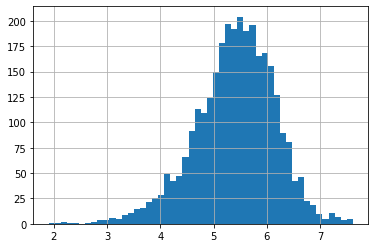

In [ ]:
combined_df.Educ_mn_avg_ol.hist(bins=50)

In [ ]:
combined_df.Food_LILATracts_1And10.describe()

count    3057.000000
mean        0.193866
std         0.234357
min         0.000000
25%         0.000000
50%         0.126068
75%         0.291556
max         1.000000
Name: Food_LILATracts_1And10, dtype: float64

In [ ]:
combined_df.Food_MedianFamilyIncome.describe()

count      3057.000000
mean      57549.060469
std       13931.146493
min       26621.941452
25%       48439.901280
50%       55748.513464
75%       63993.126821
max      138964.922115
Name: Food_MedianFamilyIncome, dtype: float64

In [ ]:
combined_df.Food_LowIncomeTracts.describe()

count    3057.000000
mean        0.446424
std         0.320869
min         0.000000
25%         0.192640
50%         0.409520
75%         0.689560
max         1.000000
Name: Food_LowIncomeTracts, dtype: float64

In [ ]:
def to_format(num):
  if num > 9999:
    return str(num)
  return "0" + str(num)
  
combined_df["formatted_counties"] = combined_df["Educ_countyid"].map(to_format)
plot = combined_df[["formatted_counties", "Educ_mn_avg_ol"]]
plot1 = combined_df[["formatted_counties", "Food_LILATracts_1And10"]]
plot2 = combined_df[["formatted_counties", "Food_LowIncomeTracts"]]
plot4 = combined_df[["formatted_counties", "Food_LA1and10"]]

The map of the educational performance variable can be seen below: darker colors indicate poorer performance. There are several regions of note where poorer performance is indicated: southern states in both the west and east exhibit poor performance.

In [ ]:
fig = px.choropleth(plot, geojson=counties, locations='formatted_counties', color='Educ_mn_avg_ol',
                           color_continuous_scale="Agsunset",
                           range_color=(1.899497, 7.617769),
                           scope="usa",
                           labels={'Educ_mn_avg_ol':'Educ_mn_avg_ol'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

There are several variables that measure low food access (food desert indicator). Below is the LILA variable which combines a low income with a low access measurement. We use this variable in one of our models, but opt for another measurement that will be discussed below. 

In [ ]:
fig1 = px.choropleth(plot1, geojson=counties, locations='formatted_counties', color='Food_LILATracts_1And10',
                           color_continuous_scale="Sunsetdark",
                           range_color=(0, 1),
                           scope="usa",
                           labels={'Food_LILATracts_1And10':'Food_LILATracts_1And10'}
                          )
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig1.show()

Output hidden; open in https://colab.research.google.com to view.

Below is the aforementioned food access variable that will be used in the majority of our models. We will use this variable in combination with a separate measurement of low income. The low access measurement is measured as a percentage of census tracts in a given county that are considered food deserts. These values are weighted by population per census tract in our dataset.

In [ ]:
fig4 = px.choropleth(plot4, geojson=counties, locations='formatted_counties', color='Food_LA1and10',
                           color_continuous_scale="Sunsetdark",
                           range_color=(0, 1),
                           scope="usa",
                           labels={'Food_LA1and10':'Food_LA1and10'}
                          )
fig4.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig4.show()

Output hidden; open in https://colab.research.google.com to view.

Below is the low income measurement used in our models. Similar to the low access variable, this variable represents a percentage of census tracts that are considered low income in a given county. The data measures low income as: "the tract’s poverty rate is greater than 20 percent; or the tract’s median family income is less than or equal to 80 percent of the State-wide
median family income; or the tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income." (from the USDA dataset documentation)

In [ ]:
fig2 = px.choropleth(plot2, geojson=counties, locations='formatted_counties', color='Food_LowIncomeTracts',
                           color_continuous_scale="Sunsetdark",
                           range_color=(0, 1),
                           scope="usa",
                           labels={'Food_LowIncomeTracts':'Food_LowIncomeTracts'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

# Clustering

We chose to run three clustering models on various subsets of the dataframe. The three models we chose are: DBSCAN, Spectral Clustering, and Agglomerative Clustering. The Spectral and Agglomerative models perform similarly and result in similar clusters. For comparison purposes, we perform Spectral and Agglomerative clustering with 4 clusters. DBSCAN is performed with an average of 50-60 clusters to demonstrate the variety of counties in the dataset. Furthermore, DBSCAN does not perform well with few clusters. Overall, the general patterns expressed by the Spectral and Agglomerative models remain consistent throughout our analysis, while DBSCAN performs poorly with the data selected.

#### Needed Function Definitions
The first 3 function definitions are used to generate the color vectors used for our cluster plots. In the DBSCAN plots, the noise values are always colored black. genColorsDBSCAN generates the colors for the DBSCAN graphs, genColorsSpec generates the colors for the Spectral Clustering graphs, and genColorsAM generates the colors for the Aggolmerative Clustering graphs. All three use random number generators to generate the rbg colors used.

The mapColors function generates the colors for the DBSCAN maps using a random number generator. The noisePoints method makes the noise points appear white on the maps so that they are distinguishable from the rest of the clusters.

In [ ]:
def genColorsDBSCAN(n_clusters_):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    colors[-1]=(0,0,0)
    for i in range(0,n_clusters_):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color
    
    cvec=[colors[label] for label in labels]
    return cvec

In [ ]:
def genColorsAM(n_clusters):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    for i in range(0,n_clusters):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color

    
    
    cvec = [colors[label] for label in labels_am] 
    return cvec

In [ ]:
def genColorsSpec(n_clusters_spec):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    for i in range(0,n_clusters_spec):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color

    
    
    cvec = [colors[label] for label in labels_rbf] 
    return cvec

In [ ]:
def mapColorsDBSCAN(numClusters):  
  colors=[]
  r = 0
  b = 0
  g = 0
  color = (r, g, b)


  for i in range(0,numClusters):
    r = random.randrange(0, 255)
    b = random.randrange(0, 255)
    g = random.randrange(0, 255)
    color = (r, g, b)
    colors.append(rgb2hex(r, g, b))

  colors.append(rgb2hex(255,255,255))

  labels=dbsc.labels_
  clusters=[]
  for label in labels:
    if(label==-1):
      clusters.append(numClusters)
    else:
      clusters.append(label)

  return colors

In [ ]:
def noisePointsDBSCAN(numClusters):  
  colors=[]
  r = 0
  b = 0
  g = 0
  color = (r, g, b)


  for i in range(0,numClusters):
    r = random.randrange(0, 255)
    b = random.randrange(0, 255)
    g = random.randrange(0, 255)
    color = (r, g, b)
    colors.append(rgb2hex(r, g, b))

  colors.append(rgb2hex(255,255,255))

  labels=dbsc.labels_
  clusters=[]
  for label in labels:
    if(label==-1):
      clusters.append(numClusters)
    else:
      clusters.append(label)

  return clusters

## DBSCAN


DBScan is density-based spacial clustering of applications with noise. It uses vector representations of the points that we want to cluster. We use values eps min_samples to determine whether or not things are clusters. The eps is some measure of distance that the algorithm can use to determine if two things are in the same cluster. The min samples is a number that indicates the fewest number of samples necessary to create a cluster. In both our two and three variable versions of the algorithm we had eps values around .03 and min_samples around 5. This gave us the fewest number of noise points while still having distinguishable clusters. In general, we had trouble finding parameters that gave us well defined clusters with few noise points using this algorithm.


### DBSCAN 2 Variables

We first run DBSCAN on 2 variables so we can plot the results in a graph. The chosen variables are a combined measurement of income and food access (LILATracts_1And10), and a measurement of educational performance (Educ_mn_avg_ol).

Before running the model, we need to verify the educational performance variable is scaled between 0 and 1. We know the LILATracts_1And10 variable already falls between 0 and 1.

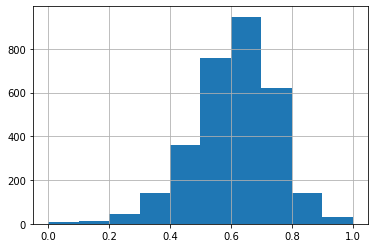

In [ ]:
educ_scaler = MinMaxScaler()
Lila_educ_normalized=combined_df[['Food_LILATracts_1And10','Educ_mn_avg_ol']]
Lila_educ_normalized['Educ_mn_avg_ol'] = educ_scaler.fit_transform(np.array(combined_df['Educ_mn_avg_ol']).reshape(-1, 1))
Lila_educ_normalized['Educ_mn_avg_ol'].hist()

In [ ]:
Lila_educ_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Food_LILATracts_1And10  3057 non-null   float64
 1   Educ_mn_avg_ol          3057 non-null   float64
dtypes: float64(2)
memory usage: 47.9 KB


In [ ]:
dbsc = DBSCAN(eps = 0.012, min_samples = 4).fit(Lila_educ_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 57
Estimated number of noise points: 560


The results of this model are plotted in the below graph. As can be seen, there is a single large cluster that is not broken into smaller clusters in this algorithm.

Text(0, 0.5, 'Educ_mn_avg_ol')

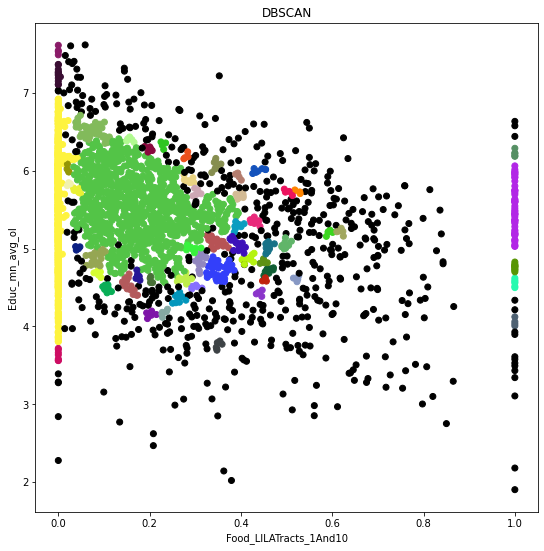

In [ ]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(combined_df['Food_LILATracts_1And10'], combined_df['Educ_mn_avg_ol'], c=cvec)
plt.title('DBSCAN')
plt.xlabel('Food_LILATracts_1And10')
plt.ylabel('Educ_mn_avg_ol')

The results of this model are plotted in a map below. The white counties are noise points. As can be seen, there is a central cluster that is similar to the low access cluster that can be seen in the low access map discussed in the previous section. However, other than that, there are no clear regional clusters visible on this map.

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = noisePointsDBSCAN(57)
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                          color_continuous_scale=mapColorsDBSCAN(57),
                          range_color=(0,57),
                          scope="usa",
                          labels={'clusters':'clusters'}
                         )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

### DBSCAN 3 Variables - 1 and 10 mile Food Desert Measurements

Below are the dataframes we will be using to run the remaining models. The are comprised of a measurement for food deserts (LA1and10, LAhalfand10, LA1and20), a measurement for income (LowIncomeTracts), and a measurement for educational performance (Educ_mn_avg_ol).

In [ ]:
LI_LA1_10_educ = combined_df[["Food_LA1and10","Food_LowIncomeTracts"]]
LI_LA1_10_educ["Educ_mn_avg_ol"] = Lila_educ_normalized["Educ_mn_avg_ol"]

LI_LAhalf_10_educ = combined_df[["Food_LAhalfand10","Food_LowIncomeTracts"]]
LI_LAhalf_10_educ["Educ_mn_avg_ol"] = Lila_educ_normalized["Educ_mn_avg_ol"]

LI_LA1_20_educ = combined_df[["Food_LA1and20","Food_LowIncomeTracts"]]
LI_LA1_20_educ["Educ_mn_avg_ol"] = Lila_educ_normalized["Educ_mn_avg_ol"]

Before running the algorithms, we need to verify that there are no missing values for any of our features. As can be seen in the tables below, there are no missing values for any of the dataframes created above.

In [ ]:
LI_LA1_10_educ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Food_LA1and10         3057 non-null   float64
 1   Food_LowIncomeTracts  3057 non-null   float64
 2   Educ_mn_avg_ol        3057 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


In [ ]:
LI_LAhalf_10_educ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Food_LAhalfand10      3057 non-null   float64
 1   Food_LowIncomeTracts  3057 non-null   float64
 2   Educ_mn_avg_ol        3057 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


In [ ]:
LI_LA1_20_educ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Food_LA1and20         3057 non-null   float64
 1   Food_LowIncomeTracts  3057 non-null   float64
 2   Educ_mn_avg_ol        3057 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


Since our previous DBSCAN 2 variable model was not successful, we run it on the new three features. The results are similar than the previous DBSCAN results in that there are no visible regional clusters that reflect the distributions of the variables besides the central cluster.

In [ ]:
dbsc = DBSCAN(eps = 0.05, min_samples = 4).fit(LI_LA1_10_educ)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 54
Estimated number of noise points: 547


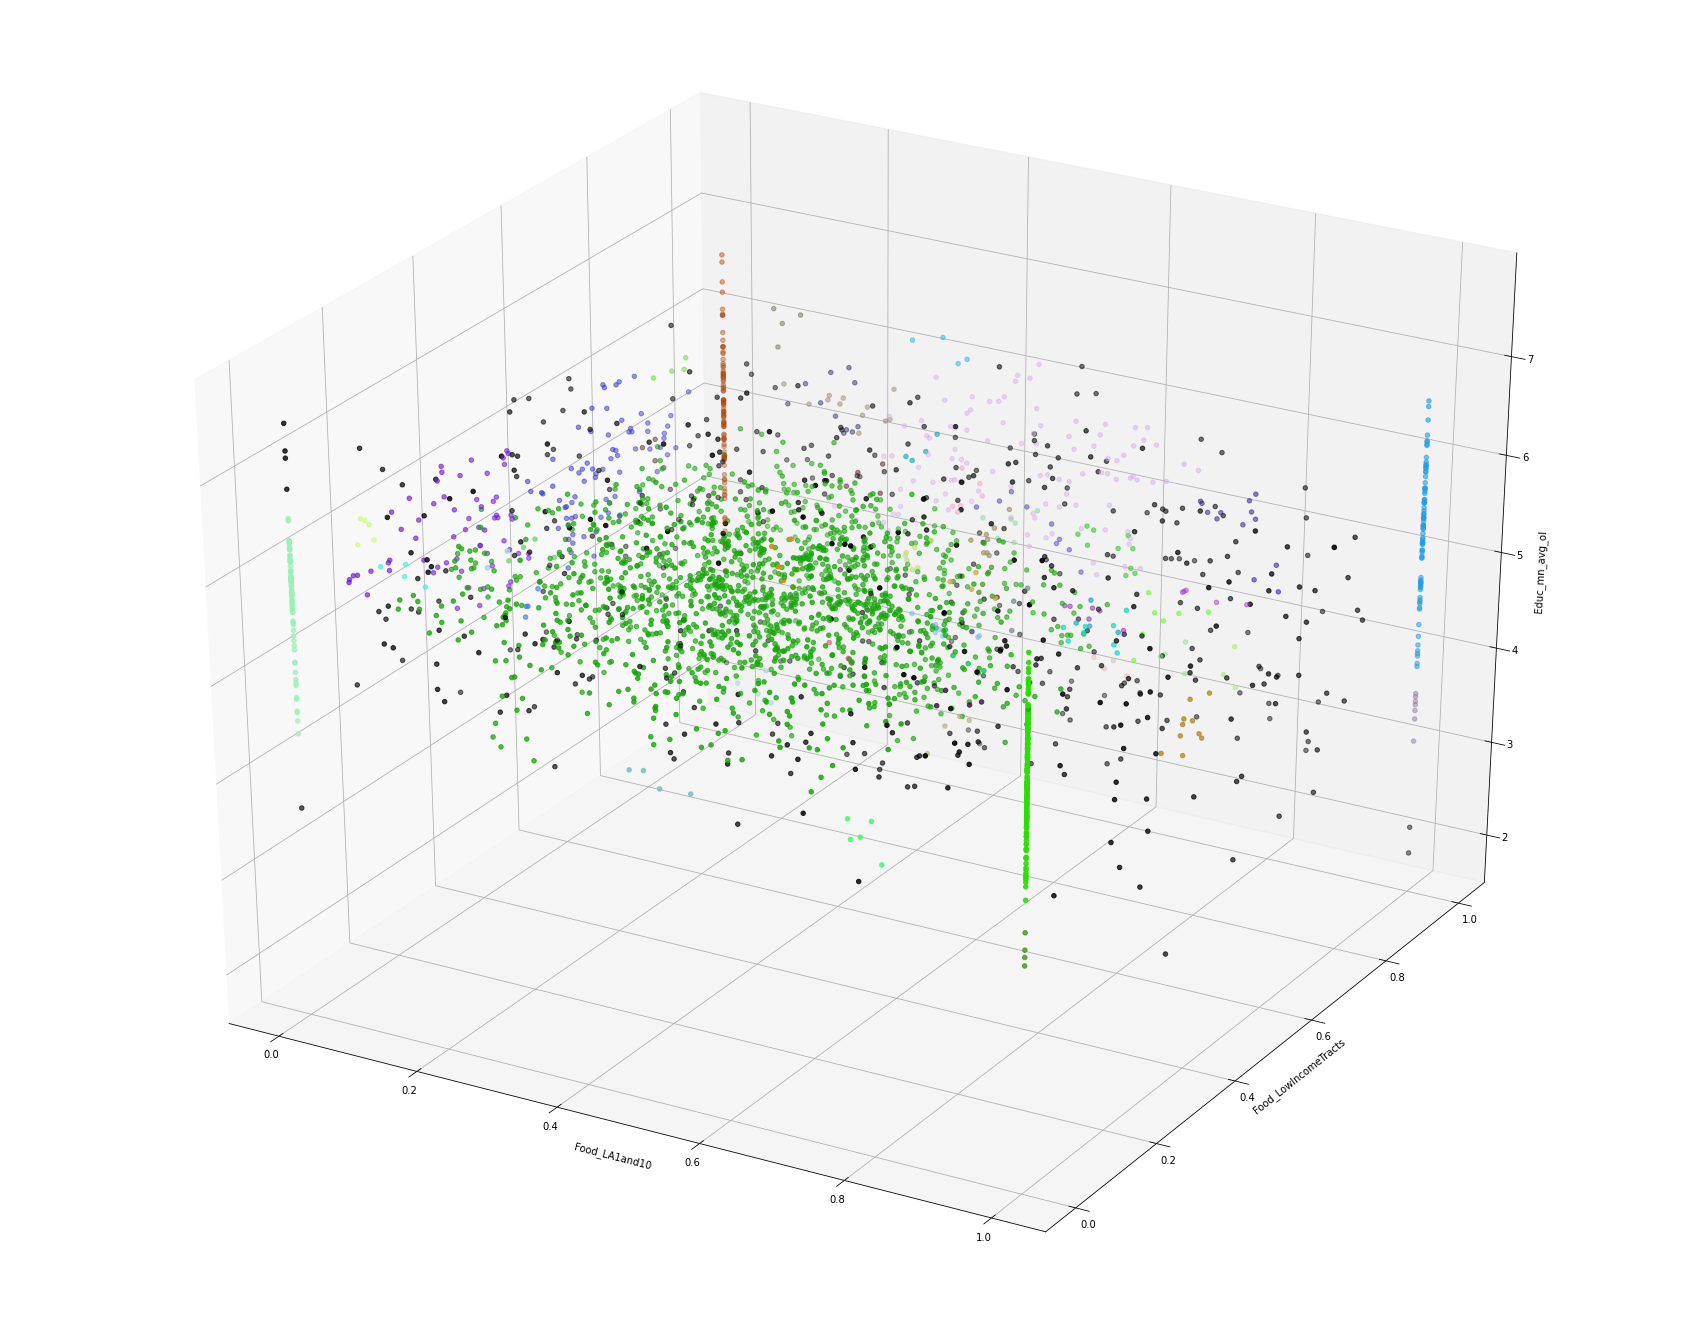

In [ ]:
cvec=genColorsDBSCAN(n_clusters_)

fig = plt.figure(figsize=(30, 24))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(combined_df['Food_LA1and10'],combined_df['Food_LowIncomeTracts'], combined_df['Educ_mn_avg_ol'], c=cvec)

ax.set_xlabel('Food_LA1and10')
ax.set_ylabel('Food_LowIncomeTracts')
ax.set_zlabel('Educ_mn_avg_ol')

plt.show()

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = noisePointsDBSCAN(54)
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=mapColorsDBSCAN(54),
                           range_color=(0,54),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

## Spectral Clustering

In spectral clustering, the data is treated as nodes in a graph. This approach to clustering is quite different than DBSCAN. DBSCAN uses the idea of compactness or density whereas clustering uses connectivity. It maps the points into a lower dimensional space and then segregates the nodes to form clusters without making any assumptions about the shape of the clusters. We used this algorithm with 4 clusters and got much better results. We have roughly equally sized clusters with understandable relationships between them.

### Spectral 3 Variables - 1 and 10 mile Food Desert Measurements

The results for this model are much more successful than DBSCAN. In the map below, we can still see the central cluster. However in addition, we note a cluster that covers the south-eastern and south-western states, and a cluster that covers parts of KY, VA, and TN.

In [ ]:
n_clusters_spec=4
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 
labels_rbf = spectral_model_rbf.fit_predict(LI_LA1_10_educ)

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_rbf
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#E8421E','#396CD9','#52CD81','#5B2263',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

### Spectral 3 Variables - 1/2 and 10 mile Food Desert Measurements

In [ ]:
n_clusters_spec=4
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 
labels_rbf = spectral_model_rbf.fit_predict(LI_LAhalf_10_educ)

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_rbf
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#E8421E','#396CD9','#52CD81','#5B2263',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

### Spectral 3 Variables - 1 and 20 mile Food Desert Measurements

In [ ]:
n_clusters_spec=4
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 
labels_rbf = spectral_model_rbf.fit_predict(LI_LA1_20_educ)

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_rbf
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#E8421E','#396CD9','#52CD81','#5B2263',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

## Agglomerative Clustering



---
Agglomerative clustering is the only heirarchical clustering algorithm that we used. It is pretty slow, but our data set is relatively small so it worked really well for us. The algorithm starts with everything as its own cluster and then combines clusters recursively. You can either use a measure of distance or linkage to combine these clusters. The distance idea is similar to dbscan whereas the linkage is similar to spectral. We used the distance method in all of our instances of this algorithm. We also looked for 4 clusters, just as we did in spectral. We had a lot of succes with this algorithm. Even though we used spatial clustering here, we got very similar results as our spectral algorithm.


### Agglomerative Clustering 1 and 10 Mile Food Desert Measurements

The results of this model are similar to the Spectral clustering results and exhibit the same 3 clusters mentioned earlier. The results for the 1 and 10 mile measurement are clearer than those for the 1/2 and 10 and 1 and 20 measurements.

In [ ]:
n_clusters_am=4
am = AgglomerativeClustering(n_clusters = n_clusters_am) 
labels_am = am.fit_predict(LI_LA1_10_educ)

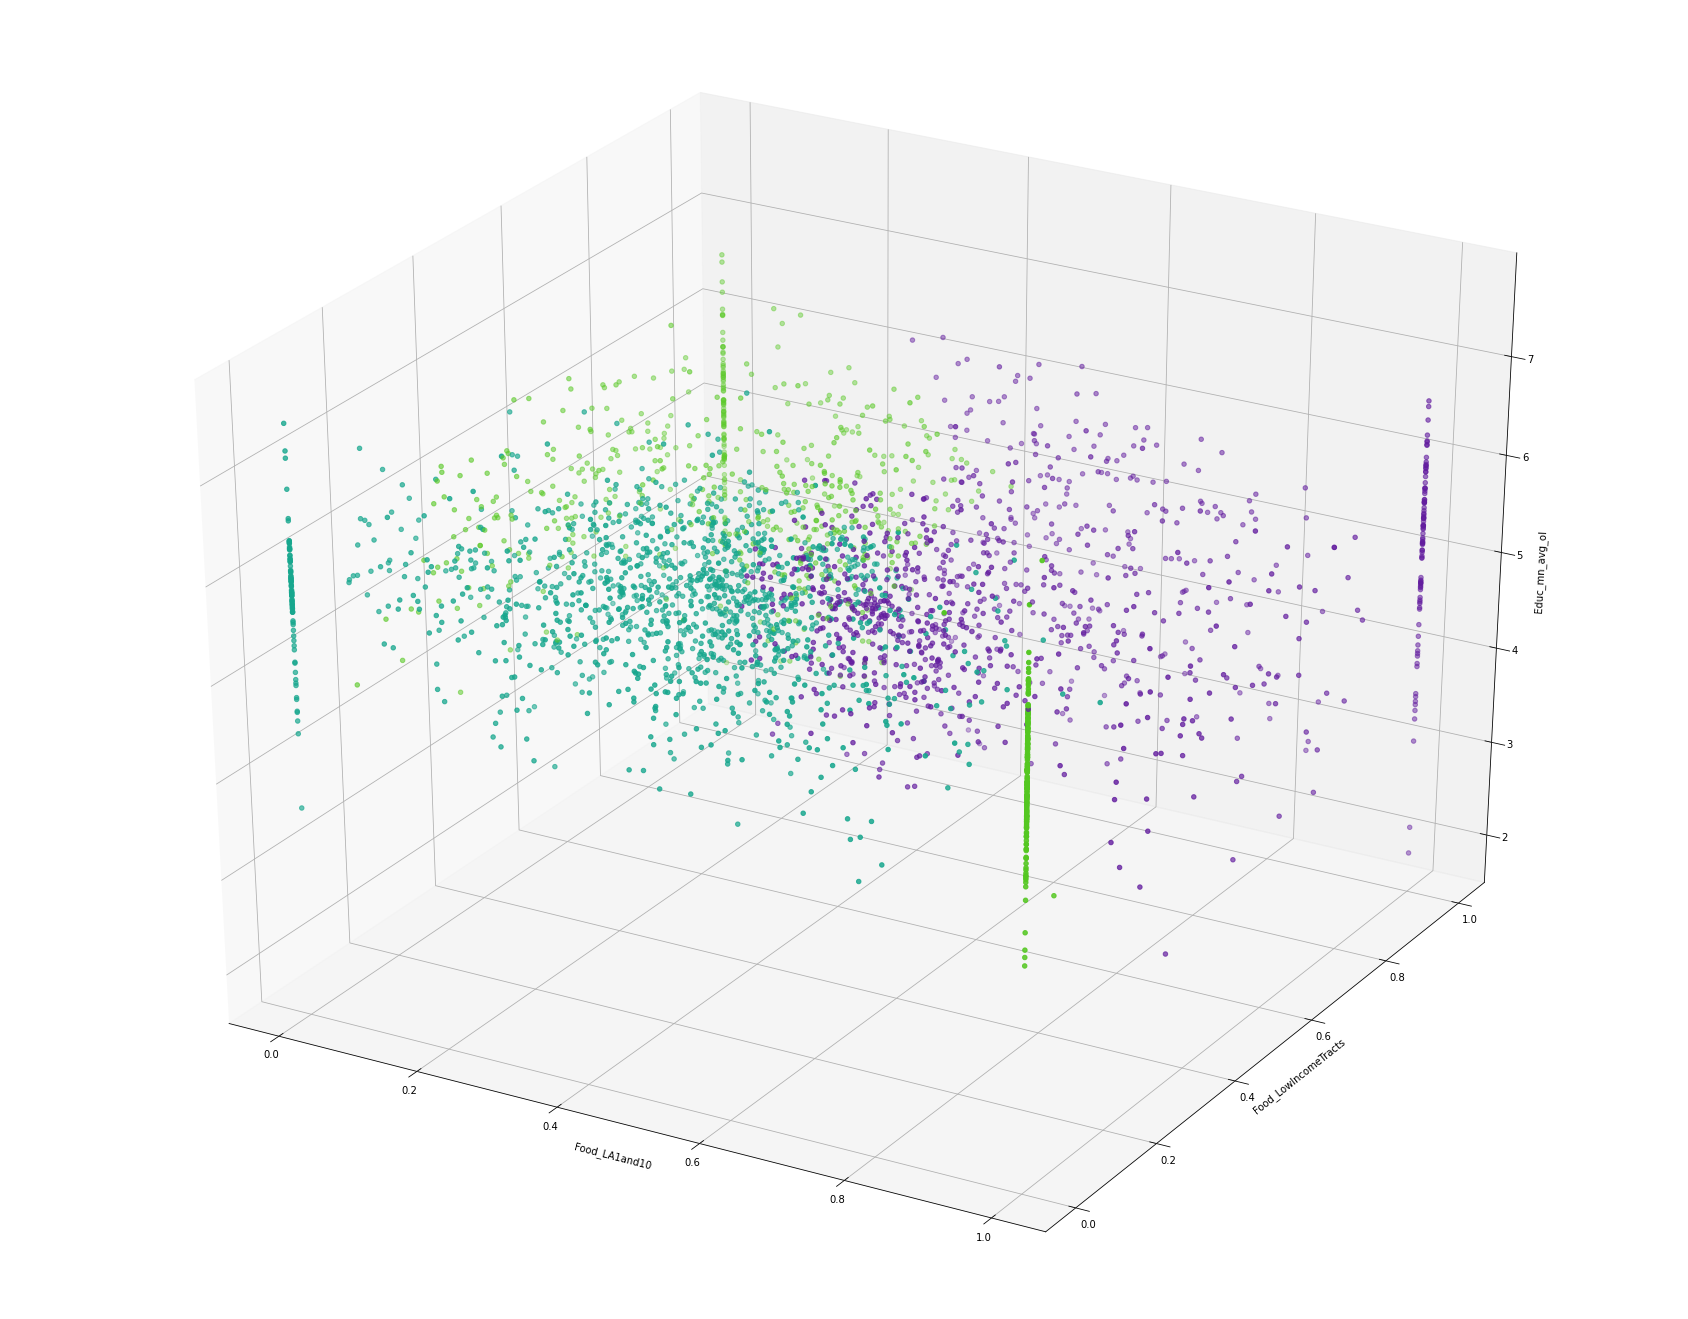

In [ ]:
cvec=genColorsAM(n_clusters_am) 

fig = plt.figure(figsize=(30, 24))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(combined_df['Food_LA1and10'],combined_df['Food_LowIncomeTracts'], combined_df['Educ_mn_avg_ol'], c=cvec)

ax.set_xlabel('Food_LA1and10')
ax.set_ylabel('Food_LowIncomeTracts')
ax.set_zlabel('Educ_mn_avg_ol')

plt.show()

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_am
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#52CD81','#396CD9','#5B2263','#E8421E',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

### Agglomerative Clustering 1/2 and 10 Mile Food Desert Measurements

In [ ]:
n_clusters_am=4
am = AgglomerativeClustering(n_clusters = n_clusters_am) 
labels_am = am.fit_predict(LI_LAhalf_10_educ)

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_am
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#5B2263','#396CD9','#52CD81','#E8421E',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

### Agglomerative Clustering 1 and 20 Mile Food Desert Measurements

In [ ]:
n_clusters_am=4
am = AgglomerativeClustering(n_clusters = n_clusters_am) 
labels_am = am.fit_predict(LI_LA1_20_educ)

In [ ]:
plot3 = combined_df[["formatted_counties"]]
plot3["clusters"] = labels_am
fig2 = px.choropleth(plot3, geojson=counties, locations='formatted_counties', color='clusters',
                           color_continuous_scale=['#396CD9','#5B2263','#52CD81','#E8421E',"#F5F890"],
                           range_color=(0,4),
                           scope="usa",
                           labels={'clusters':'clusters'}
                          )
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

## Conclusion

Overall, Spectral and Agglomerative models produced the best results. DBSCAN did not work well for our dataset and did not perform well with fewer clusters. We found the 1 and 10 mile food desert measurements to provide the best results in terms of breaking the country into clear, regional clusters.

There were several clusters of note: the central cluster reflects both high income and low food access. The cluster primarily covering the southern states reflects low income, low food access, and low performance. The cluster covering the TN/KY/VA region reflects low income and high food access. And the remaining cluster covers the rest of the remaining regions. These noteable clusters can be clearly seen in both the individual variable maps and the clustering maps for the spectral and agglomerative models.

